In [97]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(color_codes=True)
sns.set_context("paper")

# Parameter
tau = 15

In [98]:
df = pd.read_csv("/usr/app/data/trippub.csv") 
df.head()

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300
2,30000007,2,1,700,900,120,84.004,6,0,0,...,40,1500,750,50,1500,750,750,20,750,300
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,20,750,300,40,1500,750,750,40,1500,750
4,30000007,3,1,845,900,15,2.250,3,0,0,...,20,750,300,50,750,300,350,60,750,300


In [ ]:
df.shape

In [99]:
# Filter applied
# - TRPTRANS in [03, 04, 05, 06] || Mode of transportt (correspond to car, suv, van, pick up truck)
# - TRPHHVEH == '01' || Only if household vehicle is used
# - TRIPPURP in [HBO, HBSHOP, HBSCOREC, HBW]
# - TRPMILES must not be negative

# ?- Drop duplicates for combination HOUSEID + STRTTIME 

df_tmp = df[
        (df["TRPHHVEH"] == 1) 
        & (df["TRPTRANS"].isin([3, 4, 5, 6])) 
        & (df["TRIPPURP"].isin(["HBO", "HBSHOP", "HBSCOREC", "HBW"]))
        & (df["TRPMILES"] >= 0)
       ].copy()
df_tmp.shape


(423319, 115)

In [100]:
# STRTTIME for deriving probabilitiy of starting trip at time
print(df_tmp["STRTTIME"].describe())
df_tmp["STRTTIME"] = df_tmp["STRTTIME"].astype("str").apply(lambda x: int(x) if len(x) < 3 else int(int(x[0:-2])*60+int(x[-2:])))                                                         
df_tmp["STRTTIME"].describe()

count    423319.000000
mean       1307.102424
std         447.780932
min           0.000000
25%         915.000000
50%        1323.000000
75%        1700.000000
max        2359.000000
Name: STRTTIME, dtype: float64


count    423319.000000
mean        793.595778
std         268.588938
min           0.000000
25%         555.000000
50%         803.000000
75%        1020.000000
max        1439.000000
Name: STRTTIME, dtype: float64

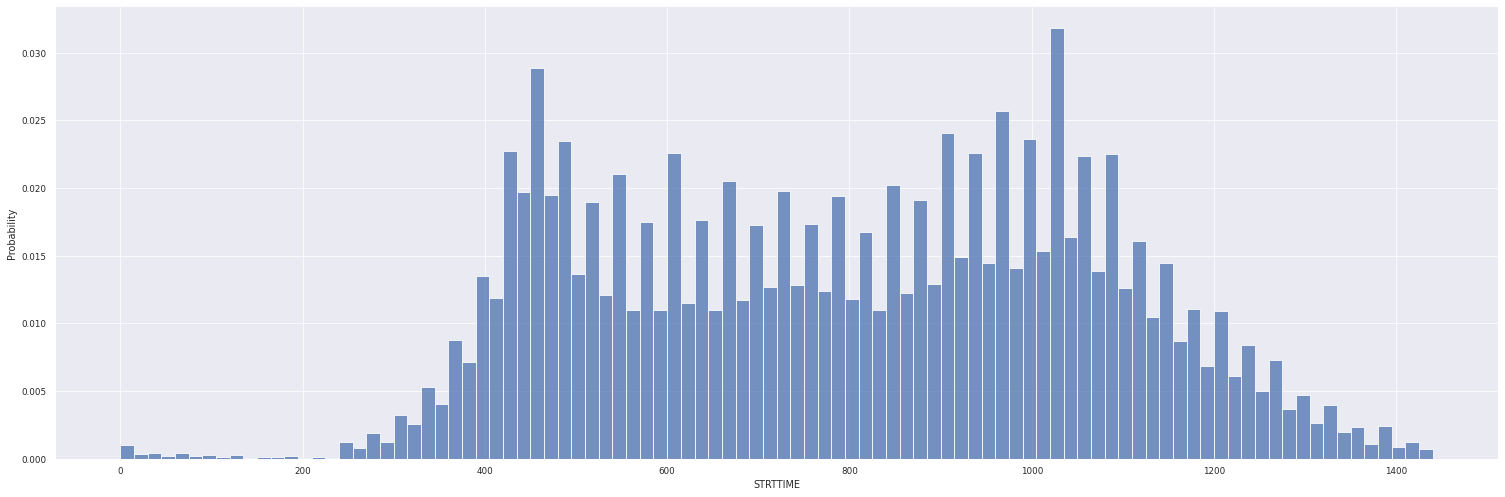

In [101]:
sns.displot(df_tmp, x="STRTTIME", stat="probability",bins=list(range(0,1441, tau)), height = 7, aspect = 3)

In [102]:
hist_strtttime = np.histogram(df_tmp["STRTTIME"], bins = list(range(0,1441, tau)), density = True)
d_strttime = pd.DataFrame(data = {"t": hist_strtttime[1][0:int(1441/tau)], "p(t)": hist_strtttime[0]*tau})
d_strttime[d_strttime["t"] < 450].tail(2)

,t,p(t)
28,420,0.022699
29,435,0.019671


In [103]:
d_strttime.to_pickle("/usr/app/data/probabilities/trpstrt.pkl") 

In [ ]:
# TRPMILES for each STRTIIME for deriving probability of Triplengt
df_tmp["TRPMILES"].describe()

In [125]:
k = 4
bins = list(range(0,41,k))  

#range(0, int(max(df_tmp["TRPMILES"])), int(max(df_tmp["TRPMILES"])/k))
d_len = pd.DataFrame(columns=["t"]+bins[:-1])

for t in d_strttime["t"]:
    hist_len = np.histogram(df_tmp.loc[df_tmp.STRTTIME==t, "TRPMILES"], bins = bins, density = True)
    d_len.loc[t,:] = [t]+list(hist_len[0]*k)
    
d_len

,t,0,4,8,12,16,20,24,28,32,36
0,0,0.326996,0.212928,0.125475,0.121673,0.0760456,0.0304183,0.0570342,0.026616,0.00760456,0.0152091
15,15,0.276596,0.404255,0.12766,0.0425532,0.106383,0.0212766,0.0212766,0,0,0
30,30,0.25,0.1875,0.1875,0.142857,0.133929,0.0535714,0.0178571,0.00892857,0.00892857,0.00892857
45,45,0.277778,0.305556,0.25,0.0277778,0.0277778,0.0555556,0,0,0.0555556,0
60,60,0.321739,0.226087,0.104348,0.0956522,0.104348,0.026087,0.0434783,0.0347826,0.0173913,0.026087
...,...,...,...,...,...,...,...,...,...,...,...
1365,1365,0.417476,0.325243,0.0679612,0.038835,0.0533981,0.0291262,0.0291262,0.00970874,0.0145631,0.0145631
1380,1380,0.31129,0.232258,0.133871,0.106452,0.0693548,0.0451613,0.0387097,0.0241935,0.0258065,0.0129032
1395,1395,0.333333,0.20155,0.155039,0.124031,0.0542636,0.0542636,0.0387597,0.00775194,0.0232558,0.00775194
1410,1410,0.276923,0.218462,0.178462,0.104615,0.0923077,0.0430769,0.04,0.0123077,0.0123077,0.0215385


In [126]:
# Save distribution
d_len.to_pickle("/usr/app/data/probabilities/trplen.pkl") 

In [127]:
# Just for checking
d_len.loc[:,'sum'] = d_len.iloc[:,1:].sum(axis=1)
#d_len.iloc[:,1:]
d_len[d_len["t"] == 300].tail(1)

,t,0,4,8,12,16,20,24,28,32,36,sum
300,300,0.15873,0.14652,0.115995,0.123321,0.105006,0.0976801,0.0732601,0.0781441,0.0549451,0.046398,1.0


<AxesSubplot:xlabel='Length', ylabel='t'>

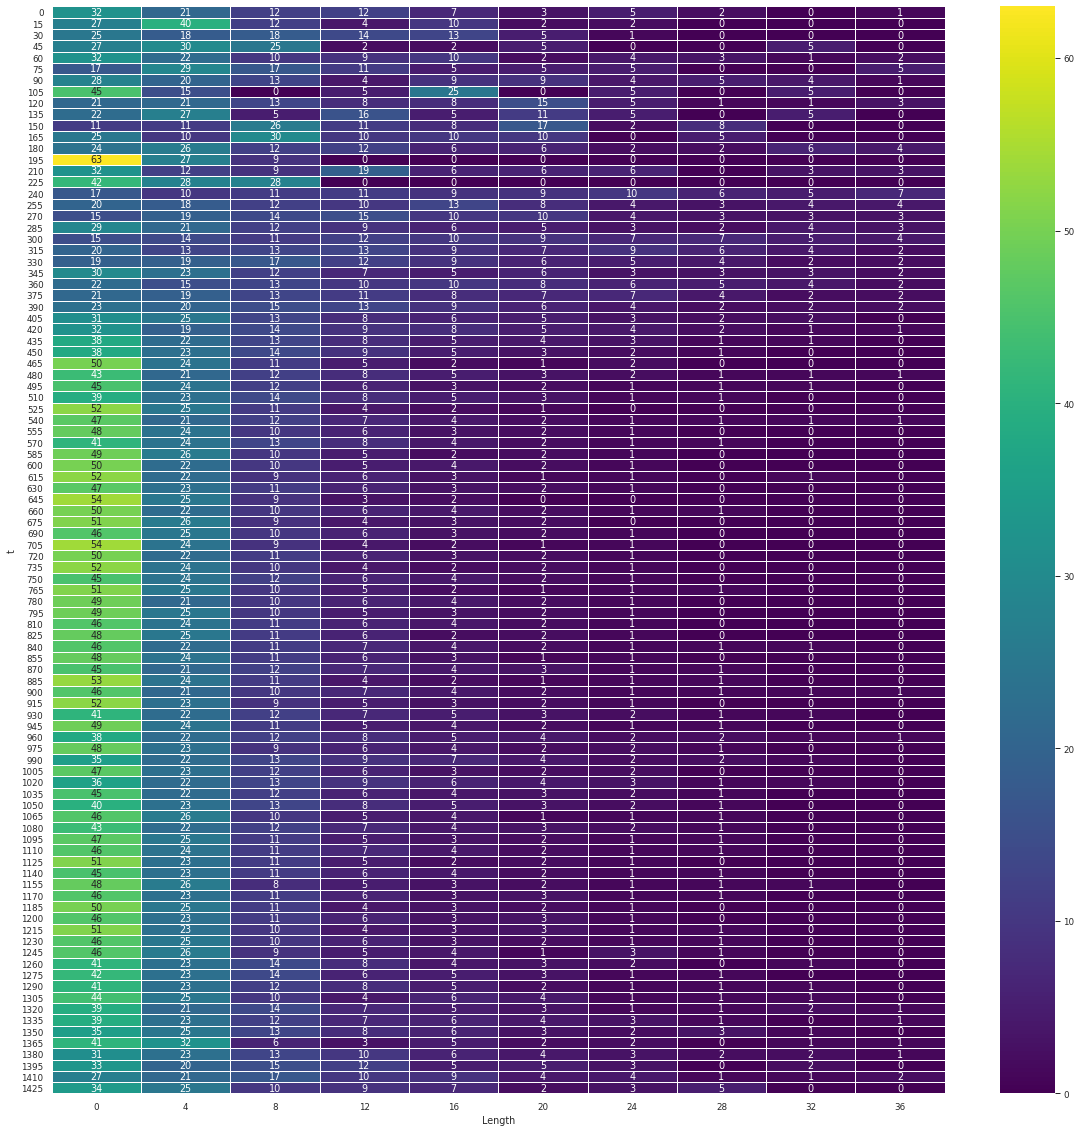

In [128]:
df_plot = pd.melt(d_len.iloc[:,:-1].copy(), id_vars=['t'], var_name = "Length", value_name = "d(t)")
df_plot["d(t)"] = df_plot["d(t)"]*100
df_plot["d(t)"] = df_plot["d(t)"].astype("int32")
df_pivot = df_plot.pivot("t", "Length", "d(t)")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_pivot, annot=True, fmt="d", linewidths=.5, ax=ax,cmap = sns.color_palette("viridis", as_cmap=True))

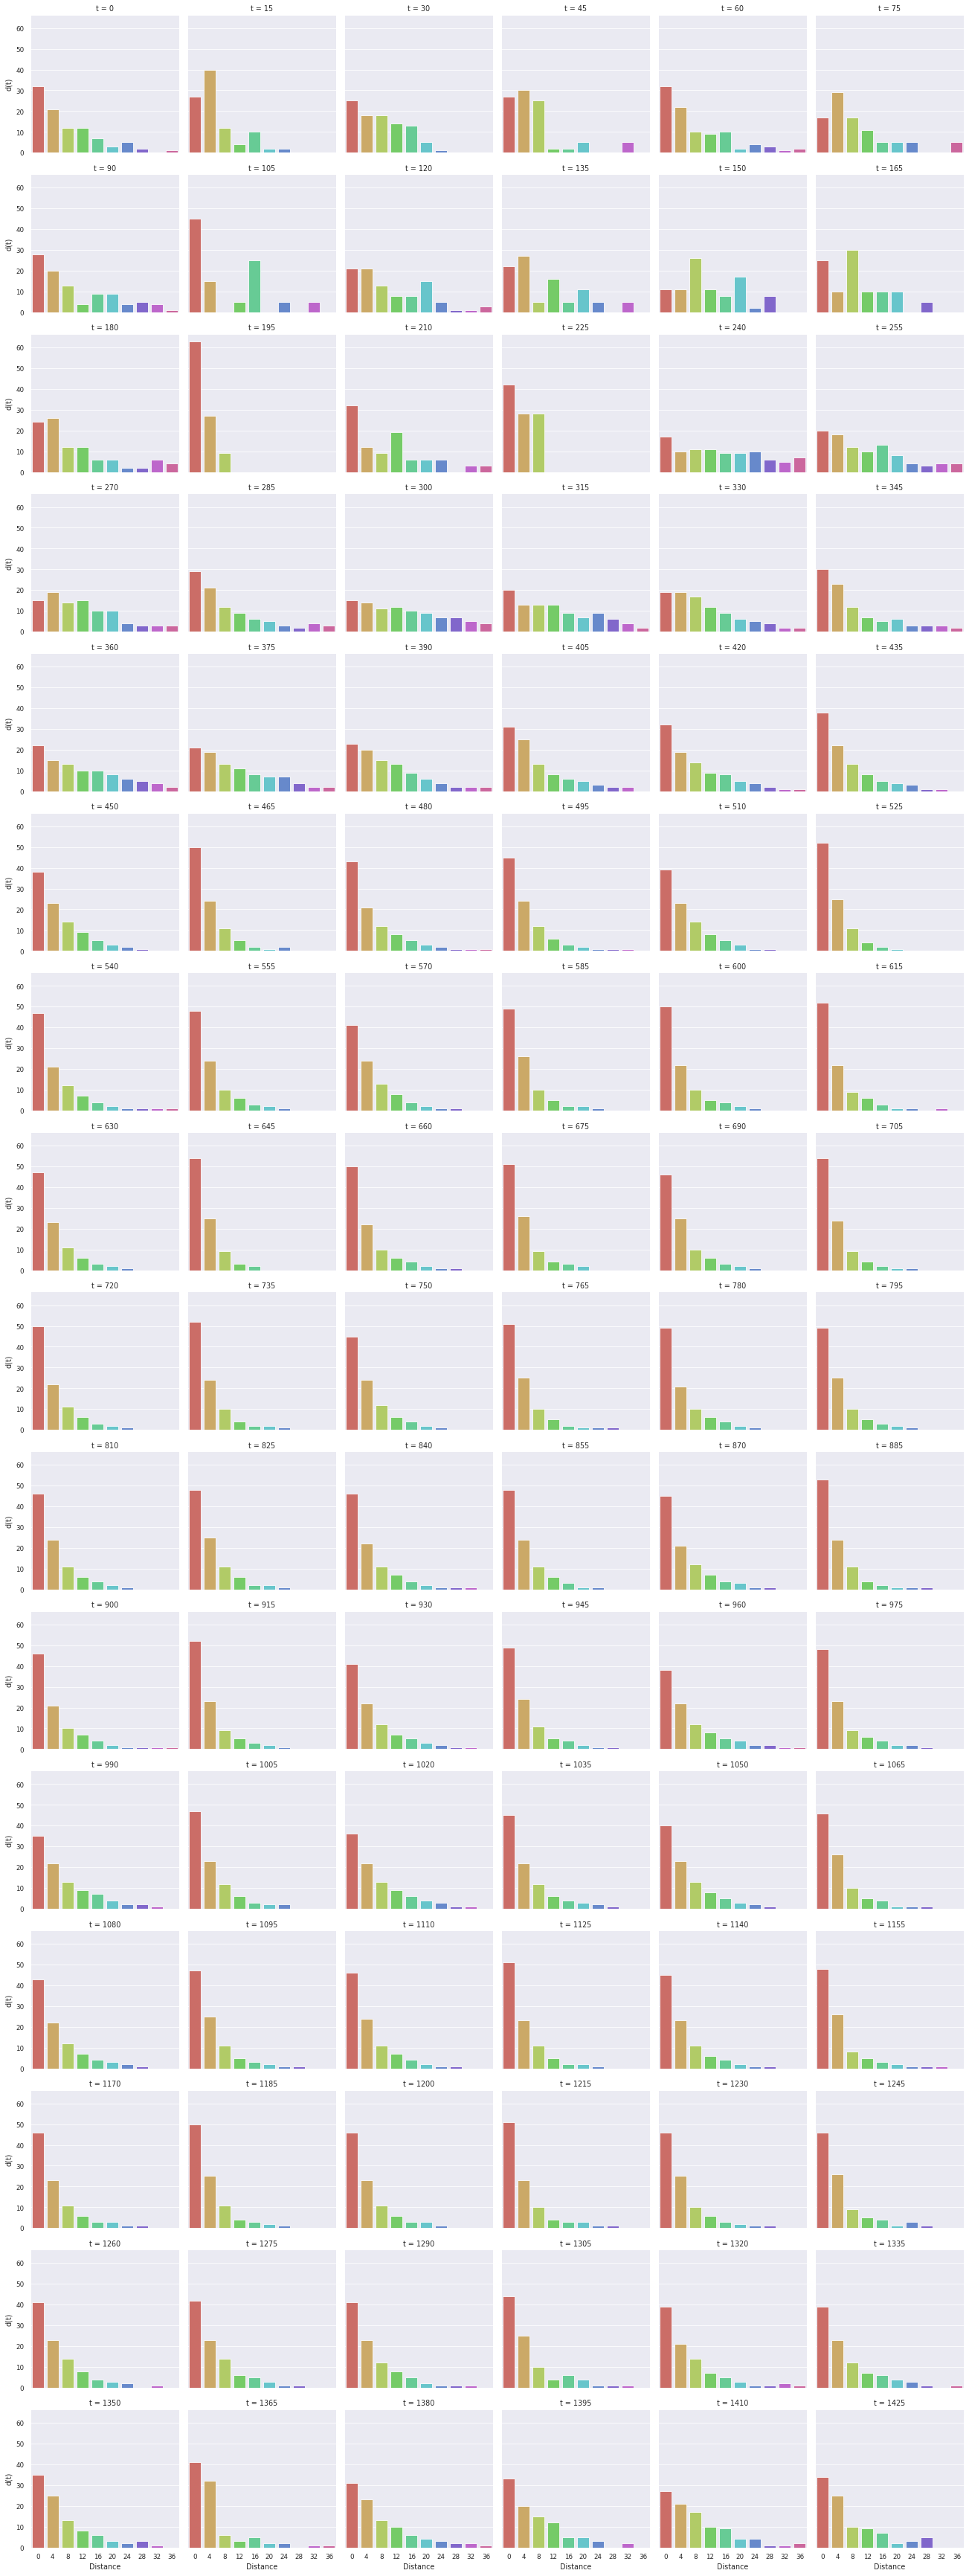

In [129]:
g = sns.FacetGrid(df_plot, col="t", col_wrap = 6)
g.map_dataframe(sns.barplot, x="Length", y="d(t)", palette = sns.color_palette("hls", len(df_plot["Length"].unique())))
g.set_axis_labels("Distance", "d(t)")

<AxesSubplot:xlabel='Length', ylabel='d(t)'>

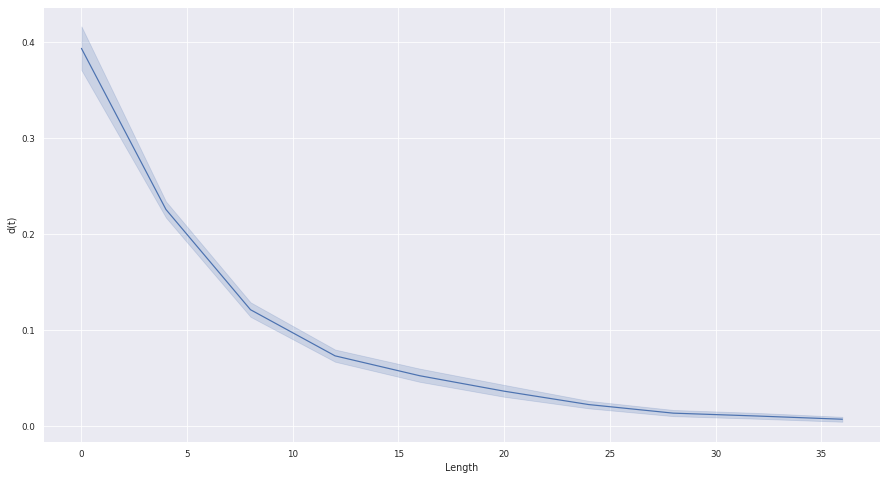

In [130]:
plt.figure(figsize=(15,8))
sns.lineplot(x=df_plot["Length"], y=df_plot["d(t)"]/100,legend = False,
            )# hue=df_plot["strttime"], palette = sns.color_palette("hls", len(df_plot["strttime"].unique())))